**DSCI 100 Final Project: Predicting Usage of a Video Game Research Server**

**Title: Predicting Minecraft Hours Played From Age Using K-Nearest Neighbors Regression**

In the Computer Science Department at UBC, Dr. Frank Wood opened a Minecraft server to examine how people play videos games. Minecraft is a popular video game, developped in 2009, that allows players to explore, build, and create in a randomly-generated terrain made of voxels. From this server, two datasets have been generated, including the one used in this project: players.csv. 

For this final project, we would like to know which "kinds" of players are most likely to contribute a large amount of data so that others can target those players in their recruiting efforts. Specifically, I want to know: *can we predict minecraft playing time based on age using the 'players.csv' dataset?*

Let's start by installing/loading the proper libraries and reading in the datafile.


In [1]:
#loading libraries for analyses - to install, use install.packages()!
library(tidyverse)
library(readr)
library(tidymodels)
library(scales)
library(janitor)

#preset the max rows shown when displaying data
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [53]:
#finding working directory
getwd()

[1] "/home/jovyan/work/dsci-100-2025-LM-project"

In [54]:
#read in the appropriate dataset called players.csv using a relative path and
#cleaning col names to remove uneccessary capitals
players <- read_delim('Data/players.csv', delim = ',', skip = 1 ) |> clean_names()
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Let's break down the variables in this dataset.
We have:
- 196 observations (Individual players)
- 7 variables ('experience', 'subscribe', 'hashed_email', 'played_hours', 'name', 'gender', and 'age')

Of these variables, we have:
1. Experience: This designates experience level of the player. While it is labeled as a character, we could use it as a factor. This variable will not be included in the following analyses.
2. Subscribe: This logic variable tells us whether the player subscribed to a video-game-related newsletter. This variable will not be included in the following analyses.
3. Hashed Email: A character string related to the player's email. This variable will not be included in the following analyses.
4. **Played Hours ('played_hours'): A Double (dbl) variable showing the total sum of hours a player spent on the Minecraft server. We will be using this variable in our analyses.**
5. Name: A character string detailing each player's first name. This variable will not be included in the following analyses.
6. Gender: A categorical (fct) variable giving the gender of each player. While shown as a character, if used, would have to be transformed into a 'fct' data type. This variable will not be included in the following analyses.
7. **Age ('age'): A double data type variable telling us the age (in years) of each player. We will be using this variable in our analyses.**

Variables used in this analyses are displayed in **bold**. 

Now that we have defined the variables, let's tale a look at our variables of interest and their distributions/summaries. We will also see if we have any NAs to deal with later in the analyses.

In [51]:
#checking for NAs in our dataset
sum(is.na(players))

[1] 2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


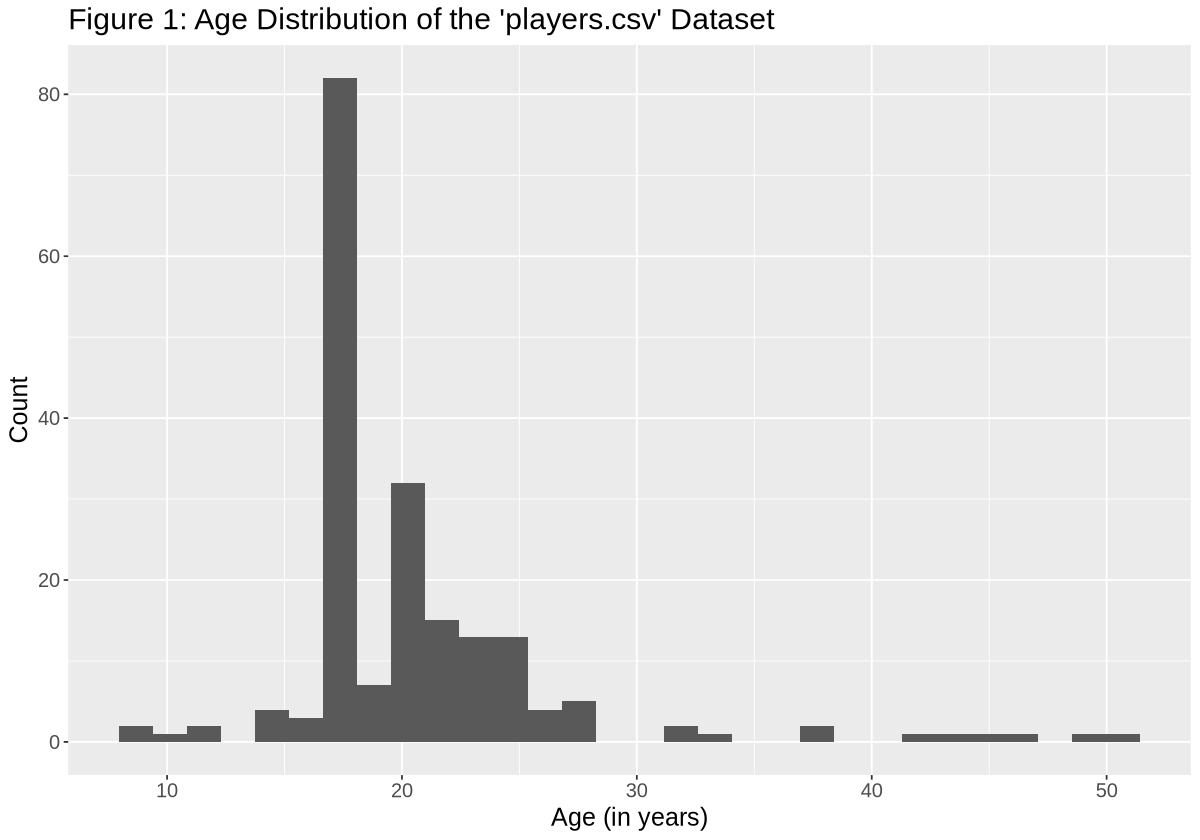

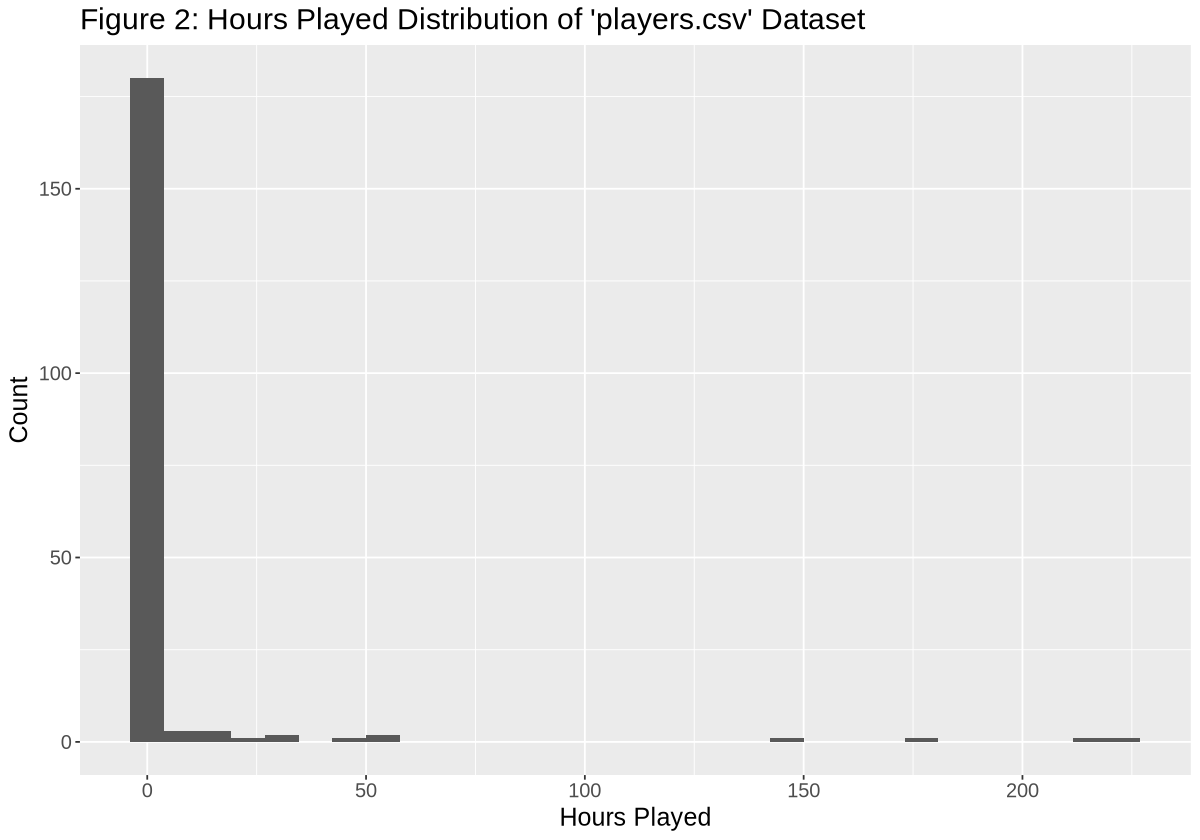

In [52]:
#plotting age and played_hours distributions

age_histogram <- players |> ggplot(aes(x = age)) + geom_histogram() + ylab("Count") + xlab("Age (in years)") + 
    theme(text = element_text(size = 15)) + ggtitle("Figure 1: Age Distribution of the 'players.csv' Dataset")
age_histogram

played_hrs_histogram <- players |> ggplot(aes(x = played_hours)) + geom_histogram() + ylab("Count") + xlab("Hours Played") + 
    theme(text = element_text(size = 15)) + ggtitle("Figure 2: Hours Played Distribution of 'players.csv' Dataset")
played_hrs_histogram

In [4]:
#summary of the dataset

summary(players, na.rm = TRUE)

  experience        subscribe       hashed_email        played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               age       
 Length:196         Length:196         Min.   : 8.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :20.52  
                                       3rd Qu.:22.00  
                                       Max.   :50.00  
                               

Limitations of this dataset:
- We have detected 2 NA values. This is quite minor and will be removed later on in the analyses.
- Our histograms show vary narrow variance, wherein most of the players fall in ages 20-30 and hours played are very low. Our summaries reflected a similar trend, wherin the average age is *M* = 20.52 (*min* = 8, *max* = 50) and average hours played being *M* = 5.85 (*min* = 0, *max* = 223.1). Interestingly, the median for hours played is 0.1, showing that the mean is being skewed by the very large values (such as our max of 223.1) and a lot of our observations are likely below this mean.

*Why might our data be so oddly distributed?* This dataset, collected at UBC, holds unique characteristics that may not hold true to other Minecraft server datasets. As the dataset was mostly collected from undergraduate students (who tend to be in their 20s) this could shew our age data. Additionally, as this data has been collected through a 100-level course, it might affect the varying amount of hours of playing (and commitment to the class assignment). This makes the data look less harder for models (specifcally those with certain data assumptions) to handle.

Now that we have explored the individual variables, let's plot our predictor (Age) and response variable (Hours Played) against each other to visualize potential relationships (and contemplate possible models).

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


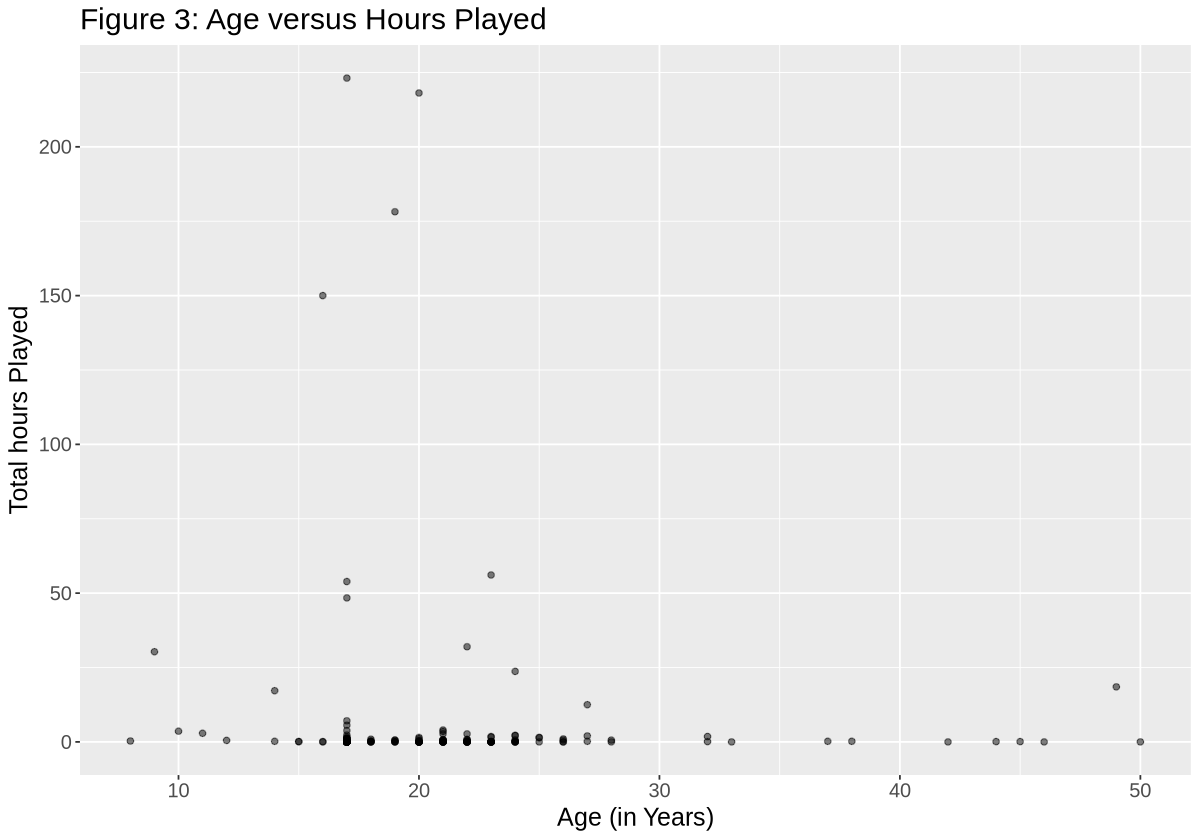

In [55]:
#setting dimensions for the plots
options(repr.plot.length = 10, repr.plot.width = 10)

#setting up the plot
playr_time_age_plot <- players |> ggplot(aes(x = age, 
                            y = played_hours)) +
                    geom_point(alpha = 0.5) +  
                    labs(color = "Did the player subscribe?") +
                    ylab("Total hours Played") + xlab("Age (in Years)") + ggtitle("Figure 3: Age versus Hours Played") +
                    theme(text = element_text(size = 15)) 

playr_time_age_plot 

As we can see in Figure 3, many of the data points are close to the x-axis, making it difficult to see the distribution clearly. Figure 4 shows the same plot using logarithmic scaling to better distribute the data across the y-axis.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


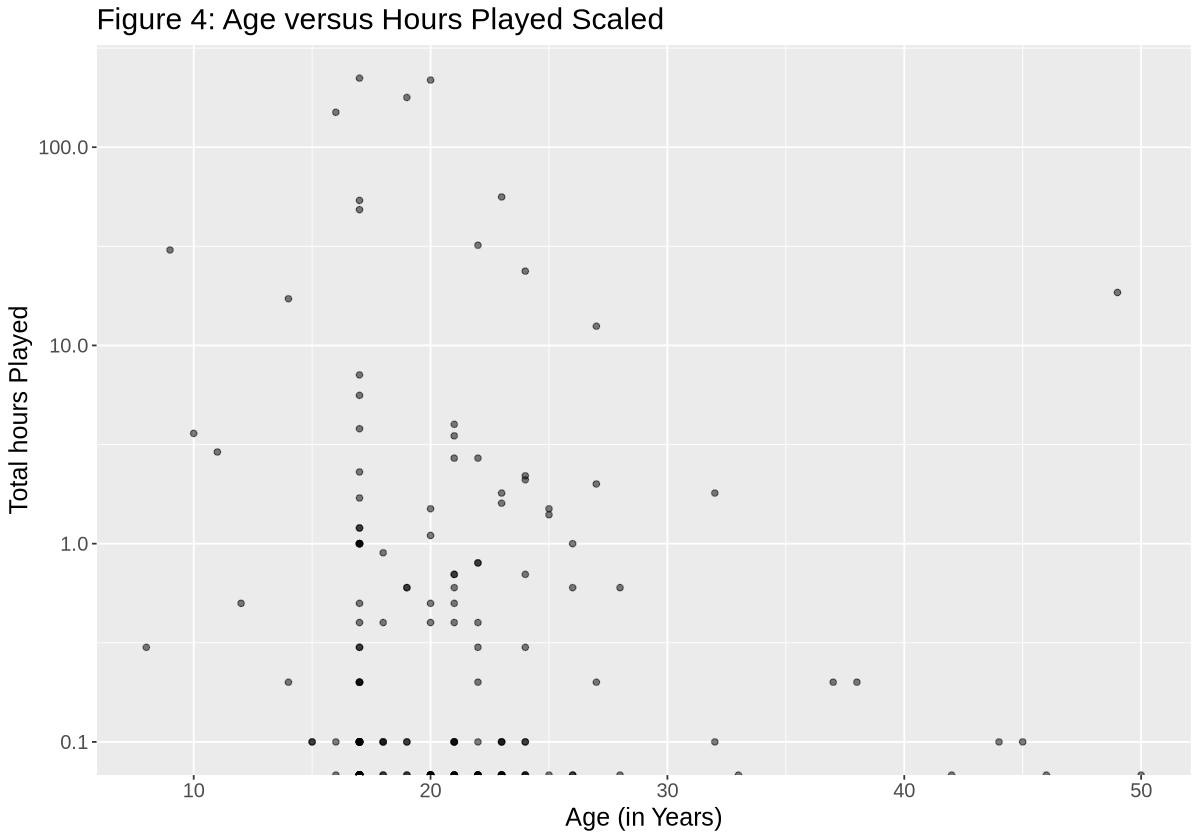

In [56]:

playr_time_age_plot_scaled <- players |> ggplot(aes(x = age, 
                            y = played_hours)) +
                    geom_point(alpha = 0.5) +  scale_y_log10() +
                    labs(color = "Did the player subscribe?") +
                    ylab("Total hours Played") + xlab("Age (in Years)") + ggtitle("Figure 4: Age versus Hours Played Scaled") +
                    theme(text = element_text(size = 15)) 

playr_time_age_plot_scaled

Here we can again confirm that a majority of our sample is young adults and hours played is mostly below 10 hours.  We also see that the data does not visibly appear to have any linearity and we cannot visually determine any strong correlations,  so we should likely use a KNN regression rather than a simple linear regression to try to predict played hours based on age. This choice was made on the basis that linear regression is typically only equipped for linear relationships, whereas KNN uses no assumptions about the data's shape. Thus, KNN is likely our best option.

Let's clean the data to answer this specific research question, removing uneccessary variables and removing NAs.

In [7]:
players_knn <- players |> select(age, played_hours) |> na.omit()
players_knn

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
⋮,⋮
22,0.3
17,0.0
17,2.3


Now we will try to build a KNN regression model for our research question and then undergo cross validation to find the best K value. Cross-validation is important as it lets us simulate several iterations of the RMSE (error) for our model to find the best K without sacrificing our testing data that we use for the final evaluation. We will split the traiing data first into a 75/25 split to allow for enough data for training the model while leaving a subset for testing later.

In [57]:
#splitting the training and testing set
knn_split <- initial_split(players_knn, prop = 0.75, strata = played_hours)
knn_training <- training(knn_split)
knn_testing <- testing(knn_split)

As the age and hours-played variable are on non-comparable scales (meaning that hours-played would hold more weight in prediction), we will standardize the data.

In [9]:
#building the model and recipe (e.g., standardizing) for tuning
knn_recipe <- recipe(played_hours ~ age, data = knn_training) |> step_center(all_predictors()) |>
    step_scale(all_predictors())
tune_knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> set_engine('kknn') |>
    set_mode('regression')

For the cross-validation, we will use the standard 5 folds so we get sufficient iterations without making our validation sets too small.

In [63]:
set.seed(1045) 
#for the purposes of consistency (for grading) I have preset the randomness - remove in real life circumstances!

#creating 5 v folds and performing cross validation to find the best K
vfolds <- vfold_cv(knn_training, v = 5, strata = played_hours)

#creating our workflow for tuning
best_k_wflw <- workflow() |> add_recipe(knn_recipe) |> add_model(tune_knn_spec) 

#setting our possible k_vals from 1-100, skipping by 10 
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

#undergoing cross-validation
best_k_metrics <- best_k_wflw |> tune_grid(resamples = vfolds, grid = k_vals) |> collect_metrics() |> filter(.metric == 'rmse')

#selecting our best K for this model according to our training data
best_reg_k <- best_k_metrics |> slice_min(mean, n=1) |> select(neighbors) |> pull()
best_reg_k
##our best K for this KNN regression is K = 32


[1] 32

Now that we have found our best K value (32), we will create a newly-tuned model and evaluate the  model on our test data.

In [67]:
#creating our newly-tuned model
knn_reg_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_reg_k) |> set_engine('kknn') |>
    set_mode('regression')

#fitting the tuned regression model on our training data
knn_reg_fit <- workflow() |> add_recipe(knn_recipe) |> add_model(knn_reg_spec) |> fit(knn_training)

#predicting the test data, assessing its RMPSE and attaching it to the testing data
knn_reg_test <- knn_reg_fit |> predict(knn_testing) |> 
        bind_cols(knn_testing) 

#evaluating the prediction error to find our RMSPE
knn_reg_test_metrics <- knn_reg_test |> metrics(truth = played_hours, estimate = .pred) |> filter(.metric =='rmse')
knn_reg_test_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,46.56235


We have our RMSPE, but it is much easier to understand the model's accuracy through a plot. Let's try that now:

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


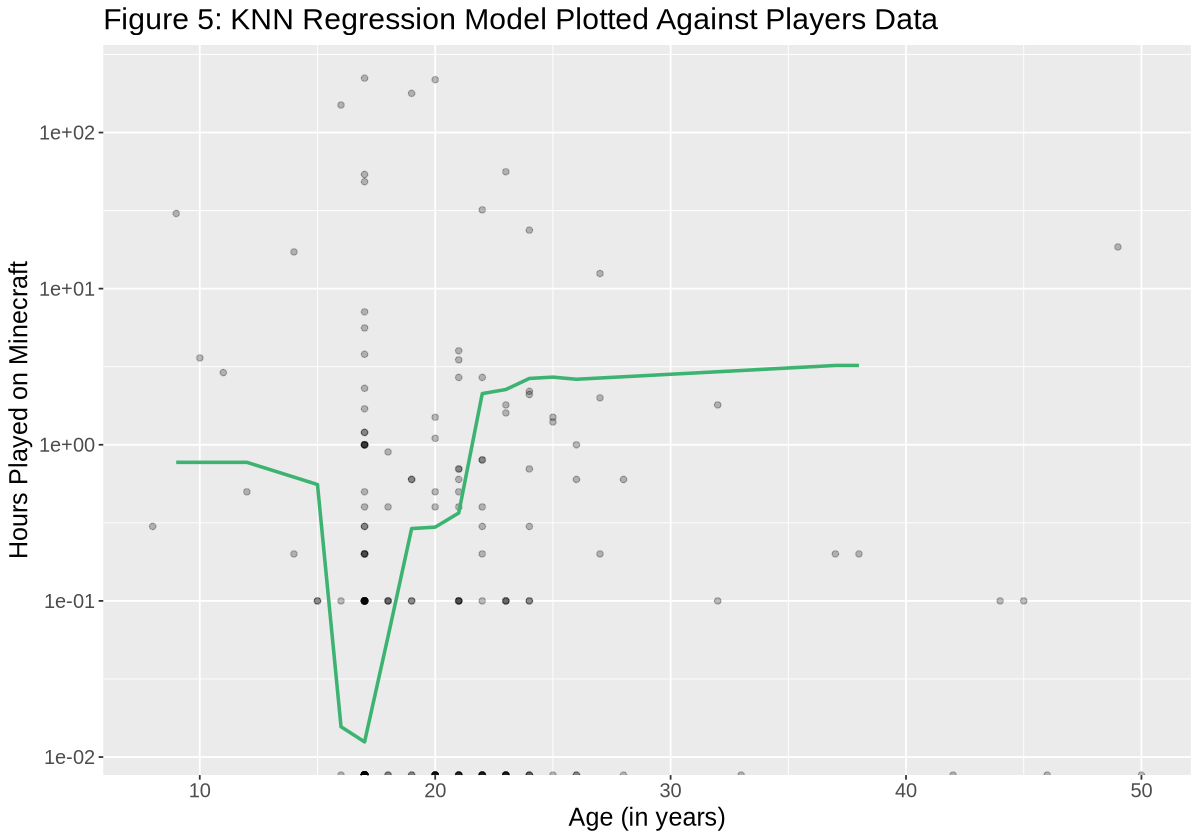

In [66]:
#plotting the actual data as a scatterplot and the model's estimate as a line plot
knn_reg_rmse_plot <- players_knn |> ggplot(aes(x = age, y = played_hours)) + geom_point(alpha = 0.25) + 
        geom_line(data = knn_reg_test, mapping = aes(x = age, y = .pred), linewidth = 1, color = 'mediumseagreen') +
        scale_y_log10() + ylab("Hours Played on Minecraft") + xlab("Age (in years)") + 
        theme(text = element_text(size = 15)) + ggtitle("Figure 5: KNN Regression Model Plotted Against Players Data")

knn_reg_rmse_plot

Based on this plot and the RMSPE, we can tell that the KNN regression model is not operating in a very helpful way. This is likely due to the strange distribution of data, wherein there are many players in the 20-30 year range and little data points in other ranges. This limits the model's ability to predict at extremes, as the KNN model starts to grab the same data points. Another flaw is that this model cannot capture the extreme variance we do see in hours played, as much of the data is very low, though there are some extreme higher values that are not being captured.

Next steps to imptove this model would to hopefully capture more data in age ranges bveyond the 20-30 year period, whichcolud help improve our model's accuracy at the extreme ends. In terms of the exteme variance we see in hours played, it could be possible that we are seeing differnt trajectories, wherein many players fall in the 0-1 playing hours range, but another subgroup is playing far more. In this case, a differnt modek (or models) might be useful to capture each trajectory, making the model more specifc and accurate.